<a href="https://colab.research.google.com/github/vladjito/nlp2021/blob/main/EXAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Березовський Владислав Юрійович, ТШІ-21, Практичне завдання іспиту з дисципліни Методи обробки природньомовної інформації, 13.12.21

#Умова

Варіант № 3

Завдання:
Розробити Jupyter Notebook для вирішення завдання класифікації тексту
на основі набору даних:
https://drive.google.com/drive/folders/1cYLsyazwxMUSICumvIhv5jGJe6K7iAHa?usp=sharing

Забезпечити виконання наступних етапів:
1. Завантаження та попередній аналіз даних.
2. Створення тренувального та тестувального наборів даних.
3. Попередню оцінку точності моделі за допомогою методу Naive Bayes.
4. Вирішення задачі класифікації за допомогою методу Feed-forward model.
5. Графічне відображення тренування моделі.
6. Порівняння результатів, отриманих у п.п. 3,4
7. Висновки.

Структура звітного документу:
Заголовок роботи (Markdown: П.І.Б., група, назва роботи (Практичне завдання іспиту з дисципліни...), дата складання.)
Етапи роботи (Номер та назва етапу (частини етапу),  код з коментарями.)

Використати технології: Tensorflow, Google Colab.
Результати викласти у форматі [your_surname].ipynb у папку Exam репозиторію GitHub.

#Завантаження та попердній аналіз даних

In [53]:
import numpy as np
import pandas as pd
import tensorflow as tf, requests as rqst, io
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras import layers

rnd = np.random.randint

In [54]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

--2021-12-13 09:02:01--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.3’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-12-13 09:02:01 (86.1 MB/s) - ‘helper_functions.py.3’ saved [10246/10246]



In [55]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [61]:
train_df = pd.read_csv("/content/drive/MyDrive/NLP/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/NLP/valid.csv")

train_df

,Id,Title,Body,Tags,CreationDate,Y
0,34552656,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,2016-01-01 00:21:59,LQ_CLOSE
1,34553034,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,2016-01-01 02:03:20,HQ
2,34553174,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,2016-01-01 02:48:24,HQ
3,34553318,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,2016-01-01 03:30:17,HQ
4,34553755,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,<android><material-design><floating-action-but...,2016-01-01 05:21:48,HQ
...,...,...,...,...,...,...
44995,60461435,Convert List<String> to string C# - asp.net - ...,<p>I am new to this and I am asking for help t...,<c#><asp.net><sql-server>,2020-02-29 02:22:18,LQ_CLOSE
44996,60461754,Does Python execute code from the top or botto...,<p>I am working on learning Python and was won...,<python>,2020-02-29 03:33:59,LQ_CLOSE
44997,60462001,how to change payment date in Azure?,<p>It looks like it costs 8 days per month in ...,<azure><billing>,2020-02-29 04:34:16,LQ_CLOSE
44998,60465318,how to implement fill in the blank in Swift,"<p>""I _____ any questions.""</p>\n\n<p>I want t...",<ios><swift>,2020-02-29 12:50:43,LQ_CLOSE


In [62]:
train_df.Y.value_counts()

LQ_CLOSE    15000
LQ_EDIT     15000
HQ          15000
Name: Y, dtype: int64

In [63]:
test_df.Y.value_counts()

LQ_EDIT     5000
LQ_CLOSE    5000
HQ          5000
Name: Y, dtype: int64

In [64]:
train_df["Sentence"] = train_df["Title"].astype(str) + " " + train_df["Body"].astype(str).str.zfill(6)
test_df["Sentence"] = test_df["Title"].astype(str) + " " + test_df["Body"].astype(str).str.zfill(6)

In [65]:
train_df.pop('Id') 
train_df.pop('Title')
train_df.pop('Body')
train_df.pop('Tags')
train_df.pop('CreationDate')
test_df.pop('Id')
test_df.pop('Title')
test_df.pop('Body')
test_df.pop('Tags')
test_df.pop('CreationDate')


0        2016-01-01 01:44:52
1        2016-01-01 08:43:50
2        2016-01-01 09:55:22
3        2016-01-01 10:43:45
4        2016-01-01 11:34:09
                ...         
14995    2020-02-29 13:32:56
14996    2020-02-29 17:46:41
14997    2020-02-29 18:35:39
14998    2020-02-29 20:32:14
14999    2020-02-29 22:45:56
Name: CreationDate, Length: 15000, dtype: object

In [66]:
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,Y,Sentence
37979,LQ_CLOSE,not able to run function in php <p>I'am not ab...
9911,HQ,Export GIT LOG into an Excel file <p>I have lo...
43386,LQ_EDIT,How to summarize the employees by net revenue ...
13822,LQ_EDIT,how to retrieve words based on user inputting ...
44810,LQ_EDIT,how to use val insted of var in scala I simply...


In [68]:
train_df['Target'] = train_df['Y']
train_df.replace({'Target':{'HQ':1, 'LQ_CLOSE':2, 'LQ_EDIT':0}}, inplace=True)

test_df['Target'] = test_df['Y']
test_df.replace({'Target':{'HQ':1, 'LQ_CLOSE':2, 'LQ_EDIT':0}}, inplace=True)

train_df

,Y,Sentence,Target
0,LQ_CLOSE,Java: Repeat Task Every Random Seconds <p>I'm ...,2
1,HQ,Why are Java Optionals immutable? <p>I'd like ...,1
2,HQ,Text Overlay Image with Darkened Opacity React...,1
3,HQ,Why ternary operator in swift is so picky? <p>...,1
4,HQ,hide/show fab with scale animation <p>I'm usin...,1
...,...,...,...
44995,LQ_CLOSE,Convert List<String> to string C# - asp.net - ...,2
44996,LQ_CLOSE,Does Python execute code from the top or botto...,2
44997,LQ_CLOSE,how to change payment date in Azure? <p>It loo...,2
44998,LQ_CLOSE,how to implement fill in the blank in Swift <p...,2


In [69]:
test_df

,Y,Sentence,Target
0,LQ_EDIT,How to get all the child records from differen...,0
1,LQ_EDIT,Retrieve all except some data of the another t...,0
2,HQ,Pandas: read_html <p>I'm trying to extract US ...,1
3,LQ_EDIT,"Reader Always gimme NULL I'm so new to C#, I w...",0
4,LQ_EDIT,php rearrange array elements based on conditio...,0
...,...,...,...
14995,LQ_CLOSE,How can I align two flex boxes to follow each ...,2
14996,LQ_CLOSE,C++ The correct way to multiply an integer and...,2
14997,LQ_EDIT,WHY DJANGO IS SHOWING ME THIS ERROR WHEN I TRY...,0
14998,LQ_CLOSE,PHP - getting the content of php page <p>I hav...,2


#Векторизація та Ембедінг

In [70]:
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

9

In [74]:
max_vocab_length = 10000
max_length = 9 

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

text_vectorizer.adapt(train_df['Sentence'])
text_vectorizer.adapt(test_df['Sentence'])

text_vectorizer(train_df['Sentence'])

<tf.Tensor: shape=(45000, 9), dtype=int64, numpy=
array([[ 163, 1951,  550, ...,  143,  314, 2656],
       [ 118,   53,  163, ...,   43,    3,  258],
       [ 115, 3742,   94, ...,  316,  642,   24],
       ...,
       [  19,    3,  175, ..., 1205,  613,  400],
       [  19,    3,  505, ..., 1597,    6,  447],
       [  19,   26,    4, ...,  158, 1017,    9]])>

In [76]:
embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=max_length) # how long is each input

embedding(text_vectorizer(test_df['Sentence']))
embedding(text_vectorizer(train_df['Sentence']))

<tf.Tensor: shape=(45000, 9, 128), dtype=float32, numpy=
array([[[ 0.03927414,  0.00396653,  0.02472028, ...,  0.03601636,
          0.00222332, -0.04184022],
        [-0.01340784, -0.02186679, -0.04677768, ..., -0.00768391,
          0.03920133, -0.04078103],
        [ 0.04304954, -0.00171451,  0.0053714 , ...,  0.02229932,
         -0.03704657, -0.04109759],
        ...,
        [-0.03823211, -0.0339885 ,  0.03883294, ...,  0.01517479,
         -0.01019276,  0.02454752],
        [ 0.02990464,  0.03403423,  0.045795  , ...,  0.03721963,
         -0.02136707,  0.00066513],
        [ 0.01611848,  0.01386014, -0.02388844, ...,  0.04274391,
         -0.04623887, -0.00642437]],

       [[ 0.02523077, -0.04995976,  0.0259284 , ..., -0.00221673,
          0.04804603,  0.0151701 ],
        [-0.01820042,  0.04126177, -0.0394427 , ..., -0.03404403,
          0.02441796,  0.03746346],
        [ 0.03927414,  0.00396653,  0.02472028, ...,  0.03601636,
          0.00222332, -0.04184022],
        ..

#Попередню оцінка точності моделі за допомогою методу Naive Bayes.

In [131]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), 
                    ("clf", MultinomialNB()) 
])

model_0.fit(train_df['Sentence'], train_df['Y'])

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [132]:
baseline_score = model_0.score(test_df['Sentence'], test_df['Y'])
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 69.92%


In [133]:
# Make predictions
baseline_preds = model_0.predict(test_df['Sentence'])
baseline_preds[:20]

array(['LQ_EDIT', 'LQ_EDIT', 'HQ', 'LQ_EDIT', 'LQ_EDIT', 'LQ_CLOSE',
       'LQ_CLOSE', 'HQ', 'HQ', 'LQ_CLOSE', 'LQ_CLOSE', 'HQ', 'LQ_CLOSE',
       'LQ_CLOSE', 'HQ', 'LQ_EDIT', 'HQ', 'HQ', 'LQ_EDIT', 'LQ_EDIT'],
      dtype='<U8')

#Вирішення задачі класифікації за допомогою методу Feed-forward

In [121]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [136]:
# Get baseline results
baseline_results = calculate_results(y_true=test_df['Y'],
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 69.92,
 'f1': 0.6928100916545702,
 'precision': 0.7239615206519482,
 'recall': 0.6992}

In [137]:
#dense neural network
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string") # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numerized numbers
x = layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding (try running the model without this layer and see what happens)
outputs = layers.Dense(3, activation="softmax")(x) # create the output layer, want binary outputs so use sigmoid activation
model_dense = tf.keras.Model(inputs, outputs, name="model_dense") # construct the model

In [138]:
model_dense.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_dense.summary()

Model: "model_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_2 (TextV  (None, 9)                0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, 9, 128)            1280000   
                                                                 
 global_average_pooling1d_4   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_4 (Dense)             (None, 3)                 387       
                                                                 
Total params: 1,280,387
Trainable params: 1,280,387
Non

In [140]:
model_dense_history = model_1.fit(train_df['Sentence'], 
                              train_df['Target'],
                              epochs=5,
                              validation_data=(test_df['Sentence'], test_df['Target']))

Epoch 1/5
1407/1407 [==============================] - 13s 9ms/step - loss: 0.4663 - accuracy: 0.7939 - val_loss: 0.7971 - val_accuracy: 0.6889
Epoch 2/5
1407/1407 [==============================] - 13s 10ms/step - loss: 0.4644 - accuracy: 0.7945 - val_loss: 0.8018 - val_accuracy: 0.6880
Epoch 3/5
1407/1407 [==============================] - 13s 9ms/step - loss: 0.4638 - accuracy: 0.7948 - val_loss: 0.8072 - val_accuracy: 0.6865
Epoch 4/5
1407/1407 [==============================] - 13s 9ms/step - loss: 0.4629 - accuracy: 0.7950 - val_loss: 0.8134 - val_accuracy: 0.6874
Epoch 5/5
1407/1407 [==============================] - 13s 9ms/step - loss: 0.4619 - accuracy: 0.7970 - val_loss: 0.8163 - val_accuracy: 0.6861


In [141]:
model_dense_pred_probs = model_dense.predict(test_df['Sentence'])

In [142]:
model_dense_preds = tf.squeeze(tf.argmax(model_dense_pred_probs, axis = 1))
model_dense_preds

<tf.Tensor: shape=(15000,), dtype=int64, numpy=array([0, 0, 1, ..., 0, 1, 1])>

In [143]:
model_dense_results = calculate_results(y_true=test_df['Y'],
                                    y_pred=model_dense_preds)
model_dense_results

ValueError: ignored

#Графічне відображення тренування моделі.

In [114]:
from matplotlib import pyplot as plt

def plot_history(history): 
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

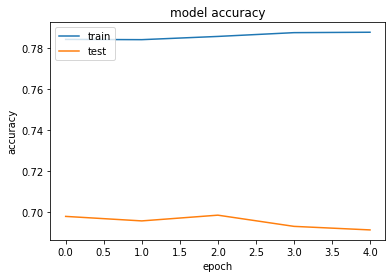

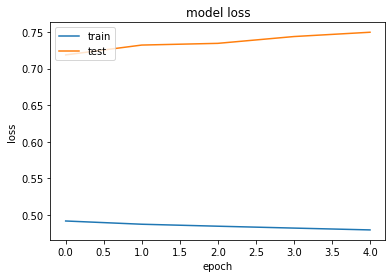

In [115]:
plot_history(model_dense_history)

#Порівняння результатів моделей

In [116]:
def compare_base_model_to_new_model(baseline_results, new_model_results):
  for key, value in baseline_results.items():
    print(f"Base model {key}: {value:.2f}, New model {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

In [117]:
compare_base_model_to_new_model(baseline_results, model_dense_results)

Base model accuracy: 69.92, New model accuracy: 42.70, Difference: -27.22
Base model precision: 0.72, New model precision: 0.41, Difference: -0.31
Base model recall: 0.70, New model recall: 0.43, Difference: -0.27
Base model f1: 0.69, New model f1: 0.39, Difference: -0.30
